# Exercise 1b
#### Tutor: Jeremias Traub
#### Kevin Heibel, Max Heise

## 1 Nearest Neighbor Classification on Real Data

### 1.1 Exploring the Data

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

digits = load_digits()
print (digits.keys())

data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]
print(data.dtype)
print(images.shape)
print(target_names)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64
(1797, 8, 8)
[0 1 2 3 4 5 6 7 8 9]


-> images have a size of 8x8

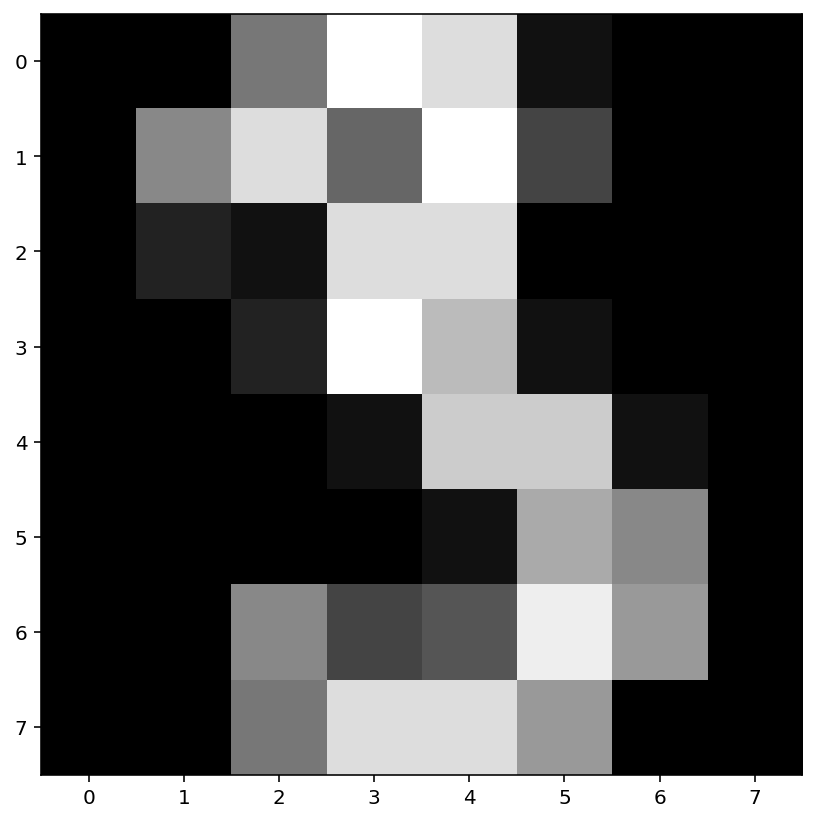

In [2]:
img = images[3]
assert 2 == len(img.shape)

plt.figure()
plt.gray()
plt.imshow(img , interpolation ="nearest")
plt.show()

In [3]:
X_all = data
y_all = target

X_train , X_test , Y_train , Y_test =\
    model_selection.train_test_split( digits.data, digits.target,
          test_size = 0.4, random_state = 0)

### 1.2 Distance function computation using loops

In [4]:
'''
computes the Euclidean distance between all instances in the training and test set (in the feature space)
input: N × D training matrices with D pixels per image and N instances in the training set
       M × D test matrices with D pixels per image and M instances in the test set
output: N × M distance matrix.
'''

def dist_loop(training, test):
    N = training.shape[0]
    M = test.shape[0]
    distance_matrix = np.zeros((N,M))
    
    for i, instance1 in enumerate(training):
        for j, instance2 in enumerate(test):
            distance = np.sqrt(np.sum(np.square(np.subtract(instance1, instance2))))
            distance_matrix[i][j] = distance
    
    return distance_matrix

### 1.3 Distance function computation using vectorization

In [5]:
'''
distance function which relies on vectorization and does not use loops
input: N × D training matrices with D pixels per image and N instances in the training set
       M × D test matrices with D pixels per image and M instances in the test set
output: N × M distance matrix.
'''

def dist_vec(training, test):
    N = training.shape[0]
    M = test.shape[0]

    training_squared = (training*training).sum(axis=1).reshape((N,1))*np.ones(shape=(1,M))
    test_squared = (test*test).sum(axis=1)*np.ones(shape=(N,1))
    distance_matrix =  np.sqrt(training_squared + test_squared - 2 * training.dot(test.T))

    return distance_matrix

In [6]:
#print((dist_loop(X_train, X_test) ==  dist_vec(X_train, X_test)).all())

In [7]:
# measure time of loop function
print("loop function:")
%timeit dist_loop(X_train, X_test)

print("voctorized function:")
%timeit dist_vec(X_train, X_test)

loop function:


20.7 s ± 824 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
voctorized function:


132 ms ± 9.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 1.4 Implement the k-nearest neighbor classifier

In [8]:
'''
k-nearest neighbor classifier
input: N × D training matrices with D pixels per image and N instances in the training set
       N corresponding true labels
       M × D test matrices with D pixels per image and M instances in the test set
       k as the number of neighbors to look at
output: N predicted Y labels
'''

def k_nearest_neighbor(X_test, X_train, Y_train, k):
    distance_matrix = dist_vec(X_train, X_test)
    Y_test = np.zeros(X_test.shape[0])
    for i, instance in enumerate(X_test):
        distances = distance_matrix[:, i:i+1]
        smallest_distance = np.array(distances[:k])
        smallest_distance_index = np.arange(k)
        for j, distance in enumerate(distances):
            if distance <= np.amax(smallest_distance):
                smallest_distance[smallest_distance.argmax()] = distance
                smallest_distance_index[smallest_distance.argmax()] = j
        Y_nearest = Y_train[smallest_distance_index]
        Y_counts = np.bincount(Y_nearest)
        Y_predict = np.argmax(Y_counts)
        Y_test[i] = Y_predict
    return Y_test

In [9]:
def error_test(Y_True, Y_Estimate):
    y_is_false = 0
    for i in range(Y_True.shape[0]):
        if (Y_True[i] != Y_Estimate[i]):
            y_is_false += 1
    return y_is_false / Y_True.shape[0]

In [10]:
#select all instances and labels of 3 and 9
X_train_restricted = X_train[(Y_train == 3) | (Y_train == 9)]
Y_train_restricted = Y_train[(Y_train == 3) | (Y_train == 9)]

X_test_restricted = X_test[(Y_test == 3) | (Y_test == 9)]
Y_test_restricted = Y_test[(Y_test == 3) | (Y_test == 9)]

for k in [1,3,5,9,17,33]:
    Y_test_predicted = k_nearest_neighbor(X_test_restricted, X_train_restricted, Y_train_restricted, k)
    print("error for k = " + str(k))
    print(error_test(Y_test_restricted, Y_test_predicted))

error for k = 1
0.013888888888888888


error for k = 3
0.027777777777777776


error for k = 5
0.041666666666666664


error for k = 9
0.013888888888888888


error for k = 17
0.020833333333333332


error for k = 33
0.027777777777777776


We couldn't see a specific trend in our calculations regarding the dependency of k, generally the error rate is extremely low. k=5 delivers the highest error rate.

### 2 Cross-validation

In [11]:
'''
randomly split the given data and labels into L folds (parts of roughly equal size)
input: N × D data matrices with D pixels per image and N instances in the data set
       N corresponding Y_labels
       L as the size of folds
output: L × S × D data matrices with D pixels per image and S instances per fold and L folds
        L × S data matrices with S labels per fold and L folds
'''

def split_folds(data, target, L):
    indices = np.arange(data.shape[0])
    indices = np.random.permutation(indices)
    data_permutated = np.zeros(data.shape)
    target_permutated = np.zeros(target.shape)
    for i,index in enumerate(indices):
        data_permutated[i] = data[index]
        target_permutated[i] = target[index]
    X_split = np.array_split(data_permutated, L)
    Y_split = np.array_split(target_permutated, L)
    return X_split, Y_split

In [12]:
L = 10
X_folds, Y_folds = split_folds(data, target, L)

k = 1
errors = np.zeros((L))
for i in range(L):
    X = np.zeros((data.shape[0] - X_folds[i].shape[0], 64))
    Y = np.zeros((target.shape[0] - Y_folds[i].shape[0]),dtype = np.dtype('int64'))
    ind1 = 0
    ind2 = 0
    for j,fold in enumerate(X_folds):
        if (j != i):
            for instance in fold:
                X[ind1] = instance
                ind1 += 1
    for j,fold in enumerate(Y_folds):
        if (j != i):
            for instance in fold:
                Y[ind2] = int(instance)
                ind2 += 1
    errors[i] = (error_test(Y_folds[i],(k_nearest_neighbor(X_folds[i], X, Y, k))))
    
print(errors.std())
print(errors.mean())


0.006083023756892491
0.011126629422718809


Sadly we didn't have the time to test different L and k values.